In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
!pip install soundfile

In [ ]:
import soundfile as sf 
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import logging as log
import os
import random
import matplotlib.pyplot as plt
import math

class DataLoader(object):
    def __init__(self, PROJECT_HOME,DATA_FOLDER,categories=[],split_seconds = 1.0):
        self.PROJECT_HOME = PROJECT_HOME
        self.DATA_FOLDER = DATA_FOLDER
        self.samplerate = None
        self.categories = categories
        self.train_data = []
        self.train_label = []
        self.test_data = []
        self.test_label = []
        self.val_data = []
        self.val_label = []   
        self.split_seconds = split_seconds     
        
    def getRandomFilePath(self):
        """Returns a random file and the given class from the dataset"""
        if(len(self.categories)>0):
            randclasAudio = random.choice(self.categories)
            folderAudios = self.PROJECT_HOME+self.DATA_FOLDER+randclasAudio+"/"
            audiosThisClass = os.listdir(folderAudios)
            return folderAudios+random.choice(audiosThisClass),randclasAudio
        else:
            return ""
    
    def readFile(self,fileName):
        self.data, self.samplerate = AudioFile(self.PROJECT_HOME+self.DATA_FOLDER+fileName)
        return self.data,self.samplerate
    
    def info(self):
        print("Project HOME_PATH: " + self.PROJECT_HOME + ".")
        
    def setCategories(self,cat):
        """Establishes the categories of the dataset in an array, it must fit with the folders"""
        self.categories = cat
    def resetDataFromLoader(self):
        """Resets all the data from the Data Loader for Training, Testing and validation"""
        self.train_data = []
        self.train_label = []
        self.test_data = []
        self.test_label = []
        self.val_data = []
        self.val_label = [] 
    def getAllFilesPath(self):
        """ Reads all the files and returns a list of the path from each file and a list of the category."""
        filesPaths = []
        filesLabels = []
        if(len(self.categories)==0):
            log.error("Missing categories.")
            return [],[]
        iCat = 0
        for cat in self.categories:
            fname = self.PROJECT_HOME+self.DATA_FOLDER+cat+"/"
            files = [v for v in os.listdir(fname) if v[0] != "."]
            nFiles = len(files)
            for file in range(0, nFiles):
                filesPaths.append(fname+files[file])
                filesLabels.append(iCat)
            iCat+=1
        return filesPaths, filesLabels

    def readFilesFromCategory(self,cat,label):
        """Reads all the files from this category"""
        fname = self.PROJECT_HOME+self.DATA_FOLDER+cat+"/"
        files = [v for v in os.listdir(fname) if v[0] != "."]
        min_duration = self.split_seconds #Split each N seconds, N can be a float.
        #split = len(files) - int(len(files)*0.30)
        nFiles = len(files)
        audio_data = np.array([])
        final_labels = []
        final_data = []
        #Dividing the audio file into 1 second audio chunks for training
        for file in range(0, nFiles):
            fAudio = Audio(fname+files[file])
            fAudio.setCategory(cat)#This category
            fAudio.read()
            splitAudios = fAudio.transformToFilterBank(N = min_duration,trimSilence = True)
            if(splitAudios is not None):
                #Add to the final audios
                final_data= final_data + splitAudios #Concatenate them
                final_labels = final_labels + ([label] * len(splitAudios)) ##Creates a list of size N with the same label.

        #labels = np.full((1, audio_data.shape[0]), label)
        return final_data,final_labels
    
    def splitTrainingTest(self,pData,labels,splitSizeTest=0.30,shuffle=True):
        """This function splits the data and its labels into training and test data.
            pData = Processed data
            splitTest= Percentage of data for testing."""
        if(shuffle):
            #To shuffle "smartly" without losing the labels, generate a list of the size of the data, shuffle it and take the values as index from the data.
            numData = len(pData) # number of data points.
            indx = list(range(0, numData))
            random.shuffle(indx)
            #Create two empty lists where the data will be copied
            pDataCopy = []
            labelsCopy = []
            #i=0 # this is the sequential index, while ix will be the index from the list.
            for ix in indx:
                pDataCopy.append(pData[ix])
                labelsCopy.append(labels[ix])
                
            pData=pDataCopy
            labels=labelsCopy
        ### Split data in this index.
        iSplit = len(labels) - int(len(labels)*splitSizeTest)
        
        dTrain = pData[:iSplit]
        dTest = pData[iSplit:]
        
        lTrain = labels[:iSplit]
        lTest = labels[iSplit:]
        
        return dTrain,lTrain, dTest, lTest
    def concatenateAudios(self,listOfAudios, axisConcat= 0):
        """
            This mehtod concatenates the audios into a single numpy array in the given axis.
            This is mainly required to join all the features from many other features.
        """
        return np.concatenate(listOfAudios, axis=axisConcat)
    def processDatasetForHMM(self):
        """Reads the audios and creates the training and testing sets.
            For HMM we make the distinction per class, as we are training each model only with the specific data to later on select from each model the most likely.
        """
        
        #cat is a generic name for speaker, command etc. according to the type of dataset.
        N = 0
        self.resetDataFromLoader() #In case there is data, clean it before using it.
        
        for cat in self.categories:
            data, label = self.readFilesFromCategory(cat,N) #N stands for the numerical label.
            ##Only for GHMM the split takes place for each CATEGORY. !!
            dataTr, labelTr, dataTst, labelTst = self.splitTrainingTest(data,label,splitSizeTest=0.30,shuffle=True)

            self.train_data.append(self.concatenateAudios(dataTr,axisConcat=0))
            self.train_label.append(labelTr)
            #By testing data do not concatenate Audios, to test them all individually!
            #In this way we can have more predictions.
            self.test_data.append(dataTst)
            self.test_label.append(labelTst)
            N +=1

        return self.train_data,self.train_label,self.test_data,self.test_label


      
class Audio(object):
    def __init__(self, fileName):
        self.data = None
        self.samplerate = None        
        self.fileName = fileName
        self.category=None #Textual category
        self.label=None #Numerical label
        
    def read(self):
        """Reads the audio to get the raw data and sample rate"""
        self.data, self.samplerate = sf.read(self.fileName)
        return self.data,self.samplerate
    def readToGMMHMM(self):
        """Reads the audio in the format of a Gaussian Mixture Model"""
        self.read()
        splitAudios = self.transformToFilterBank(N=1.0,trimSilence=True) # Min
        audioInGMMHMMFormat = np.concatenate(splitAudios, axis=0)
        return audioInGMMHMMFormat
    def showAudio(self):
        """Shows the audio in the jupyter notebook"""
        if(self.data.any()):
            return ipd.Audio(data=self.data, rate=self.samplerate)
        else:
            log.warning("Read file first")
            return None
        
    def plotAudio(self,title=None):
        """Plots the audio"""
        if(self.data.any()):
            plt.figure(figsize=(14, 5))
            librosa.display.waveplot(self.data, sr=self.samplerate)
            if(title is None):
                plt.title(self.fileName)
            else:
                plt.title(title)
        else:
            log.warning("Read file first") 
            
    def setCategory(self,cat):
        """Set the textual category"""
        self.category = cat
        
    def setLabel(self,lab):
        """Set the numerical label"""
        self.label = lab
        
    def MFCC_features(self,n_mfcc=20):
        """Generates the features of this audio and returns them."""
        if (self.audio.any()):
            mfcc_feat = librosa.feature.mfcc(y=self.audio, sr=self.samplerate, n_mfcc=20)
            mfcc_delta = librosa.feature.delta(mfcc_feat)
            features = np.hstack((mfcc_feat.T,mfcc_delta.T))
            return features            
        else:
            return None
        
    def MFCC(self,aud_d,rate,n_mfcc=20):
        """Generates the features of the given audio and returns it."""
        mfcc_feat = librosa.feature.mfcc(y=aud_d, sr=rate, n_mfcc=n_mfcc)
        mfcc_delta = librosa.feature.delta(mfcc_feat)

        features = np.hstack((mfcc_feat.T,mfcc_delta.T))

        return features

    def melSpectrogram_features(self, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80,numSeconds = 5):
        """ Extracts the Mel Spectogram features from a file."""
        #wav,sr = librosa.load(file_path,sr=sr)
        self.read()
        
        if self.data.shape[0]<numSeconds*self.samplerate:
            self.data=np.pad(self.data,int(np.ceil((numSeconds*self.samplerate-self.data.shape[0])/2)),mode='reflect')
        else:
            self.data=self.data[:numSeconds*self.samplerate]
        spec=librosa.feature.melspectrogram(self.data, sr=self.samplerate, n_fft=n_fft,
                    hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
        spec_db=librosa.power_to_db(spec,top_db=top_db)
        return spec_db

    def spec_to_image(self, spec, eps=1e-6):
        """ Transforms the given spectogram to an image."""
        mean = spec.mean()
        std = spec.std()
        spec_norm = (spec - mean) / (std + eps)
        spec_min, spec_max = spec_norm.min(), spec_norm.max()
        spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
        spec_scaled = spec_scaled.astype(np.uint8)
        return spec_scaled

    def showSpectogramImage(self,spec):
        plt.imshow(spec, cmap='gray', vmin=0, vmax=255)
        plt.show()        

    def splitAudioOld(self,min_duration,deltaT):
        """Splits the file in chunks:
            min_duration: seconds to split the audio.
            deltaT: ##Missing a description from this##
        """

        #data,samplerate = sf.read(self.fileName) #we use the soundfile library instead of our own Audio.read to save memory by not storing it.
        if(not self.samplerate):
            self.read()#Read the data
            
        dataT, index = librosa.effects.trim(self.data)
        duration = len(dataT)*1./self.samplerate
        
        audio_data = []
        
        if duration >= min_duration: 
            #Split in n Chunks
            numChunks = int(duration/deltaT)
            sizeChunk = int(len(dataT)/numChunks)
            for lp in range(0,numChunks):    
                chunk = dataT[lp*sizeChunk:(lp+1)*sizeChunk]
                audio_data.append(self.MFCC(chunk,self.samplerate)) # Using default n_mfcc=20
            print("MFCC SHAPE: ",audio_data[-1].shape)

        if(len(audio_data)==0):
            #not minimum size to make a prediction
            ##Handle not splitable audios
            #return self.MFCC(dataT,self.samplerate)
            return None
        else:
            return audio_data          
    def transformToFilterBank(self, N = 1.0, trimSilence = True):
        """ N are the seconds to split the audio."""
        #self.data, self.samplerate
        signal = self.data
        sample_rate = self.samplerate

        # trim silent edges
        if trimSilence:
            signal, _ = librosa.effects.trim(signal)

        #lenSignal = len(signal)
        #secondsSignal = lenSignal/sample_rate

        splitSize = int(N * sample_rate)
        
        fb_signal =  self.audioToFilterBank(signal, sample_rate)
        fb_signal = fb_signal#*-1.0
        #Rescale between 0 and 255.

        #fb_signal /= np.max(np.abs(fb_signal),axis=0)
        #fb_signal *= ((255.0)/fb_signal.max())
        #Normalize now to values between 0 and 255
        fb_signal = np.interp(fb_signal, (fb_signal.min(), fb_signal.max()), (0, 255))

        #fb_signal.shape[1] contains the size of the audio (Seconds*Sampling_rate) but in case of padding, we don't use the theoretic size but the one after applying the filter bank.
        #splitSize
        #Seconds to centiseconds
        splitSize = int(N*100)
        #We only care about complete chunks, the redundant data is then discarded.
        #N_chunks = int(fb_signal.shape[1] / splitSize)
        N_chunks = math.ceil(fb_signal.shape[1] / splitSize)
        audios_transformed = []
        Nfilters, Nsamples = fb_signal.shape
        for i in range(N_chunks):
            
            if( ((i+1)*splitSize) <= Nsamples):
                signal_chunk = fb_signal[: , i*splitSize:((i+1)*splitSize)]  # Keep the first N seconds
            else:
                # Add a padding with the mean of each filter!
                missingN = Nsamples- (i*splitSize)
                partialChunk = fb_signal[: , i*splitSize:]
                meanOfFilters = np.mean(partialChunk,1) # Mean in the y axis
                NrightMissing = splitSize - missingN
                #The missing part will be filled with the mean of each filter along the whole rest of the filter.
                fillingChunk = np.vstack([meanOfFilters]*NrightMissing).T

                signal_chunk = np.concatenate((partialChunk,fillingChunk), axis=1)
            ## Transpose to fit the models that later concatenate all the outputs in the axis 1.
            audios_transformed.append(signal_chunk.T)
        return audios_transformed

    def audioToFilterBank(self, signal,sample_rate,α = 0.97, frame_size = 0.025, frame_stride = 0.01,nfilt = 40,low_freq_mel = 0,NFFT = 512):
        """ Converts a raw signal into a filter bank.
        α = High pass filter parameter, usually 0.95 or 0.97"""
        # Consult from: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html
        # http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
        # 
        #High pass filter
        emphasized_signal = np.append(signal[0], signal[1:] - α * signal[:-1])

        # Framing
        frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
        signal_length = len(emphasized_signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]    

        # Window
        frames *= np.hamming(frame_length)

        # Fourier-Transform and Power Spectrum
        mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
        pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum    

        # Filterbank
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((NFFT + 1) * hz_points / sample_rate)

        fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
        filter_banks = 20.0 * np.log10(filter_banks)  # dB  

        #Mean Normalization
        filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
        return filter_banks.T

In [ ]:
import sys
import os
sys.path.append("..") # Adds higher directory to python modules path. This is important to load the libraries  in PROJECT_HOME/src/

speakers = ['1272', '1462', '1673', '174', '1919', '251', '422', '652', '777', '84', '2412', '2428', '2803', '3853', '6241', '3536', '5895', '3576', '1988', '5536',
            '1993', '2035', '2078', '2086', '2277', '2902', '3000', '3170', '3752', '5338', '5694', '6295', '6313', '6319', '6345', '7850', '7976', '8297', '8842', '3081']
#speakers = ['1272', '1462', '1673', '174', '1919', '251', '422', '652', '777', '84']
#speakers = ["84","174","251","422"]

#PROJECT_HOME = os.getcwd()+"/"
# NOTE that in this Jupyter notebook, the parent folder is the project home, not this!
PROJECT_HOME = "gdrive/My Drive/"

SI_DATA="data/libri/" #Speaker identification dataset.
checkpointPath = PROJECT_HOME+"checkpoints/"

dataSI = DataLoader(PROJECT_HOME,SI_DATA,speakers)
filesP,filesL = dataSI.getAllFilesPath()

dTrain,lTrain, dTest, lTest = dataSI.splitTrainingTest(filesP,filesL,splitSizeTest=0.30,shuffle=True) #Shuffle before getting the Training/Test

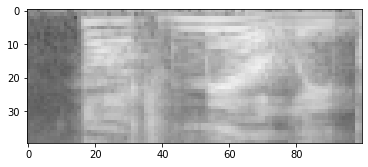

In [ ]:
sAudio = Audio(PROJECT_HOME+SI_DATA+"174/174-84280-0015.flac")
sAudio.read()
#Preprocessing Audio 
sFilBank = sAudio.transformToFilterBank(N=1.0,trimSilence=True)
sAudio.showSpectogramImage(sFilBank[2].T)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

class DatasetAudio(Dataset):
  def __init__(self,files,labels,categories):
    self.data=[]
    self.labels = labels #A list of the labels in numerical.
    self.categories = categories
    self.input_shape = [0,0,0] # Define the shape of the files
    self.sampleRates = []
    self.samples = []
    self.seconds = []
    nFiles = len(files)
    tmpLabels = []
    for i in tqdm(range(0, nFiles)):
        fAudio = Audio(files[i])
        samp, sr = fAudio.read()
        self.samples.append(len(samp))
        self.sampleRates.append(sr)
        self.seconds.append(len(samp)/sr)

        sFilBank_list = fAudio.transformToFilterBank(N=1.0,trimSilence=True)        
        for sImage in sFilBank_list:
          sImage = sImage.T #Important! The image should have as first axis the filters and as second the features itself.
          self.data.append(sImage[np.newaxis,...])#Transform in 3D with a new axis.
          tmpLabels.append(self.labels[i])
    # Reassign the expanded labels
    self.labels = tmpLabels

  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]
print("Reading Training Data")
train_data = DatasetAudio(dTrain,lTrain,speakers)
print("Reading Testing Data")
valid_data = DatasetAudio(dTest,lTest,speakers)

Reading Training Data


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Reading Testing Data


In [ ]:
#Statistics of the dataset:
import pandas as pd

dfSI = pd.DataFrame(list(zip(lTrain,train_data.samples,train_data.sampleRates,train_data.seconds,dTrain)),columns=["Category","Samples Length","Sample Rate","Seconds","Path"])
dfSI.head(10)

Category  ...                                               Path
0         4  ...  gdrive/My Drive/data/libri/1919/1919-142785-00...
1        12  ...  gdrive/My Drive/data/libri/2803/2803-154328-00...
2        32  ...  gdrive/My Drive/data/libri/6313/6313-76958-003...
3        37  ...  gdrive/My Drive/data/libri/8297/8297-275155-00...
4         9  ...  gdrive/My Drive/data/libri/84/84-121550-0013.flac
5        31  ...  gdrive/My Drive/data/libri/6295/6295-64301-002...
6         3  ...  gdrive/My Drive/data/libri/174/174-50561-0013....
7        37  ...  gdrive/My Drive/data/libri/8297/8297-275154-00...
8         7  ...  gdrive/My Drive/data/libri/652/652-130726-0001...
9        29  ...  gdrive/My Drive/data/libri/5338/5338-284437-00...

[10 rows x 5 columns]

In [ ]:
  if torch.cuda.is_available():
    device=torch.device('cuda:0')
  else:
    device=torch.device('cpu')

  #If there are cuda problems, direct everything to the cpu.
  #device=torch.device('cpu')
  print(device)

cuda:0


In [ ]:
train_loader = DataLoader(train_data, batch_size=25, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=25, shuffle=True)

In [ ]:
class FCN(nn.Module):
    #This architecture comes from reference [2]
    def __init__(self,num_cats):

        self.name = 'FCN'

        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(8,8))
        self.conv1_bn = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=(5,5))
        self.conv2_bn = nn.BatchNorm2d(256)
        self.conv3 = nn.Conv2d(256, 128, kernel_size=(3,3))
        self.conv3_bn = nn.BatchNorm2d(128)
        self.globalAvgPool =  nn.AvgPool2d(27, 87)
        self.fc1 = nn.Linear(128, num_cats)

    def forward(self, x):
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = self.globalAvgPool(x)
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return x


num_epochs = 50
learning_rate = 0.01

model = FCN(num_cats = len(train_data.categories)).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
tr_ls_fcn =[]
ts_ls_fcn = []
acc_train_fcn = []
acc_test_fcn = []

for epoch in range(num_epochs):

    train_loss = 0.0
    correct = 0
    total = 0
    test_loss = 0.0

    test_loss = []
    train_loss = []
    
    #SGD - Training
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    acc_train_fcn.append(correct/total * 100)

    #Testing
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('After %d epoch, Train Loss: %.3f, Test Loss: %.3f, Test Accuracy: %d %%' %
      (epoch+1, np.mean(train_loss), np.mean(test_loss), correct/total * 100) )
    acc_test_fcn.append(correct/total * 100)
    ts_ls_fcn.append(np.mean(test_loss))
    tr_ls_fcn.append(np.mean(train_loss))

print('Training completed')

After 1 epoch, Train Loss: 3.494, Test Loss: 3.368, Test Accuracy: 8 %
After 2 epoch, Train Loss: 3.087, Test Loss: 2.968, Test Accuracy: 16 %
After 3 epoch, Train Loss: 2.686, Test Loss: 2.590, Test Accuracy: 25 %
After 4 epoch, Train Loss: 2.288, Test Loss: 2.183, Test Accuracy: 34 %
After 5 epoch, Train Loss: 1.944, Test Loss: 1.965, Test Accuracy: 42 %
After 6 epoch, Train Loss: 1.626, Test Loss: 1.624, Test Accuracy: 52 %
After 7 epoch, Train Loss: 1.383, Test Loss: 1.412, Test Accuracy: 58 %
After 8 epoch, Train Loss: 1.201, Test Loss: 1.294, Test Accuracy: 63 %
After 9 epoch, Train Loss: 1.033, Test Loss: 1.223, Test Accuracy: 67 %
After 10 epoch, Train Loss: 0.913, Test Loss: 1.133, Test Accuracy: 70 %
After 11 epoch, Train Loss: 0.816, Test Loss: 1.063, Test Accuracy: 72 %
After 12 epoch, Train Loss: 0.722, Test Loss: 1.042, Test Accuracy: 74 %
After 13 epoch, Train Loss: 0.648, Test Loss: 1.039, Test Accuracy: 76 %
After 14 epoch, Train Loss: 0.569, Test Loss: 0.946, Test Acc

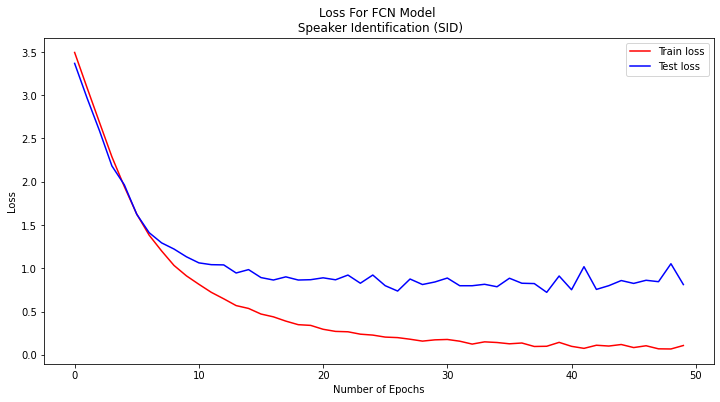

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12,6))

plt.plot(tr_ls_fcn, label='Train loss',color="#ff0000")
plt.plot(ts_ls_fcn, label='Test loss',color="#0000ff")

plt.title('Loss For FCN Model \n Speaker Identification (SID)') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.show()

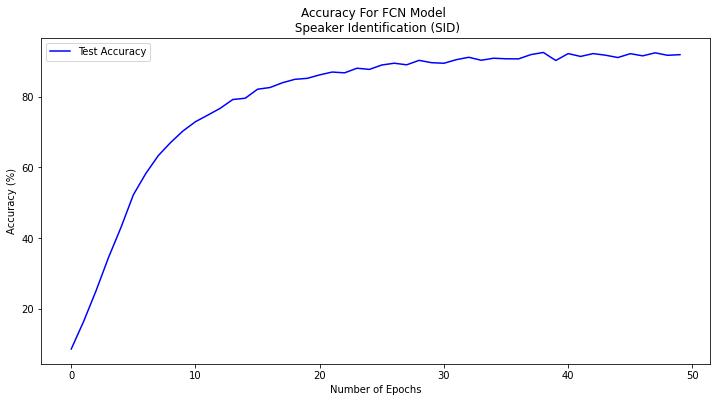

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(acc_train_fcn,label='Train Acuuracy',color="#ff0000")
plt.plot(acc_test_fcn,label='Test Accuracy',color="#0000ff")

plt.title('Accuracy For FCN Model \n Speaker Identification (SID)') 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
train_loader = DataLoader(train_data, batch_size=25, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=25, shuffle=True)

In [ ]:
from torch_layer_normalization import LayerNormalization

class CNN(nn.Module):
    #This architecture comes from reference [2]
    def __init__(self,num_cats):

        self.name = 'CNN'

        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=(8,8))
        self.conv1_bn = nn.BatchNorm2d(50)

        self.conv2 = nn.Conv2d(50, 100, kernel_size=(5,5))
        self.conv2_bn = nn.BatchNorm2d(100)

        self.conv3 = nn.Conv2d(100, 50, kernel_size=(3,3))
        self.conv3_bn = nn.BatchNorm2d(50)

        self.fc1 = nn.Linear(900, 400)
        self.drop1 = nn.Dropout()
        self.fc2 = nn.Linear(400, 100)
        self.drop2 = nn.Dropout()
        self.fc3 = nn.Linear(100, num_cats)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_bn(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv3_bn(self.conv3(x)), 2))
        #x = x.view(-1, x.size(0))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


num_epochs = 50
learning_rate = 0.001

model = CNN(num_cats = len(train_data.categories)).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
tr_ls_cnn =[]
ts_ls_cnn = []
acc_train_cnn = []
acc_test_cnn = []

for epoch in range(num_epochs):

    train_loss = 0.0
    correct = 0
    total = 0
    test_loss = 0.0

    test_loss = []
    train_loss = []
    
    
    #SGD - Training
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    acc_train_cnn.append(correct/total * 100)   
    #Testing
    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('After %d epoch, Train Loss: %.3f, Test Loss: %.3f, Test Accuracy: %d %%' %
      (epoch+1, np.mean(train_loss), np.mean(test_loss), correct/total * 100) )
    acc_test_cnn.append(correct/total * 100)
    ts_ls_cnn.append(np.mean(test_loss))
    tr_ls_cnn.append(np.mean(train_loss))

print('Training completed')

After 1 epoch, Train Loss: 2.932, Test Loss: 2.506, Test Accuracy: 17 %
After 2 epoch, Train Loss: 2.105, Test Loss: 2.041, Test Accuracy: 33 %
After 3 epoch, Train Loss: 1.637, Test Loss: 1.512, Test Accuracy: 49 %
After 4 epoch, Train Loss: 1.206, Test Loss: 1.146, Test Accuracy: 61 %
After 5 epoch, Train Loss: 0.875, Test Loss: 0.989, Test Accuracy: 71 %
After 6 epoch, Train Loss: 0.641, Test Loss: 0.772, Test Accuracy: 78 %
After 7 epoch, Train Loss: 0.499, Test Loss: 0.817, Test Accuracy: 81 %
After 8 epoch, Train Loss: 0.411, Test Loss: 0.644, Test Accuracy: 84 %
After 9 epoch, Train Loss: 0.332, Test Loss: 0.722, Test Accuracy: 86 %
After 10 epoch, Train Loss: 0.264, Test Loss: 0.620, Test Accuracy: 88 %
After 11 epoch, Train Loss: 0.246, Test Loss: 0.669, Test Accuracy: 88 %
After 12 epoch, Train Loss: 0.202, Test Loss: 0.800, Test Accuracy: 89 %
After 13 epoch, Train Loss: 0.197, Test Loss: 0.643, Test Accuracy: 90 %
After 14 epoch, Train Loss: 0.178, Test Loss: 0.721, Test Ac

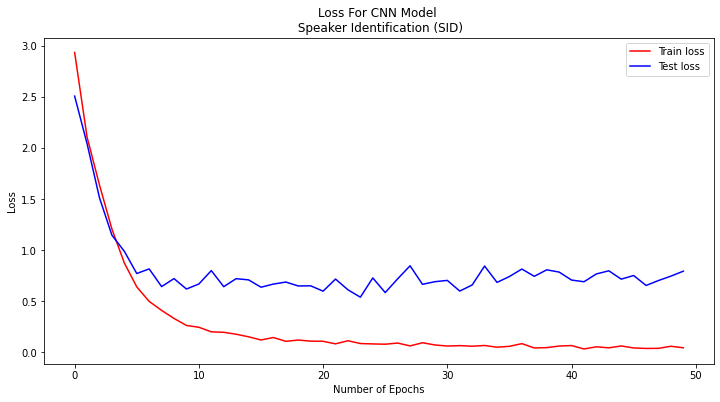

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(tr_ls_cnn, label='Train loss',color="#ff0000")
plt.plot(ts_ls_cnn, label='Test loss',color="#0000ff")

plt.title('Loss For {} Model \n Speaker Identification (SID)'.format(model.name)) 
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss')
plt.legend()
plt.show()

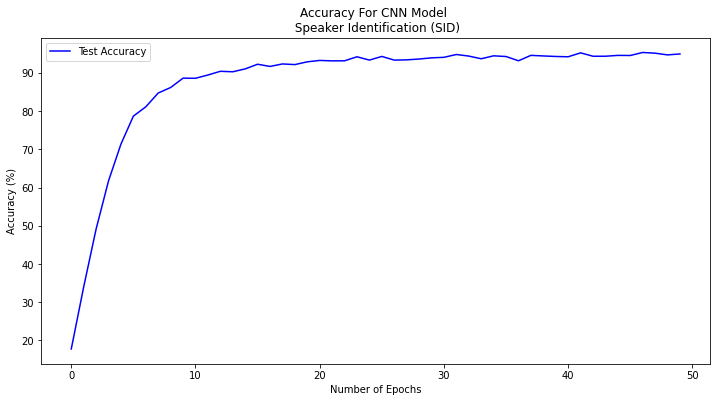

In [ ]:
plt.figure(figsize=(12,6))
#plt.plot(acc_train_cnn,label='Train Acuuracy',color="#ff0000")
plt.plot(acc_test_cnn,label='Test Accuracy',color="#0000ff")

plt.title('Accuracy For {} Model \n Speaker Identification (SID)'.format(model.name)) 
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()